In [103]:
import numpy as np
import pandas as pd
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint

In [104]:
dataset = pd.read_csv('../dataset/recruitment_data.csv', sep=',', decimal='.')
features = list(dataset.columns.values)
target = features.pop(-1)

features.remove('Age')
features.remove('Gender')
features.remove('PreviousCompanies')
features.remove('DistanceFromCompany')
dataset

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0
...,...,...,...,...,...,...,...,...,...,...,...
1495,48,0,2,3,4,9.183783,66,3,80,3,1
1496,27,1,2,10,3,14.847731,43,97,7,2,0
1497,24,1,1,1,2,4.289911,31,91,58,1,1
1498,48,0,2,4,4,36.299263,9,37,44,2,1


In [105]:
corr = dataset.corr()
corr_target = corr['HiringDecision']
corr_target.sort_values(ascending = False)
corr_target

Age                    0.001850
Gender                -0.002249
EducationLevel         0.236710
ExperienceYears        0.122494
PreviousCompanies      0.044025
DistanceFromCompany   -0.016791
InterviewScore         0.146064
SkillScore             0.203668
PersonalityScore       0.169177
RecruitmentStrategy   -0.477552
HiringDecision         1.000000
Name: HiringDecision, dtype: float64

<Axes: xlabel='HiringDecision', ylabel='count'>

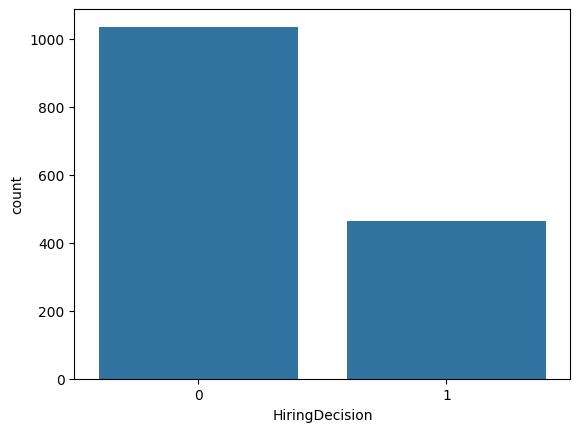

In [106]:
X = dataset[features].to_numpy()
Y = dataset[target].to_numpy()
random_seed = 11

sb.countplot(x=target,data=dataset)

<Axes: ylabel='count'>

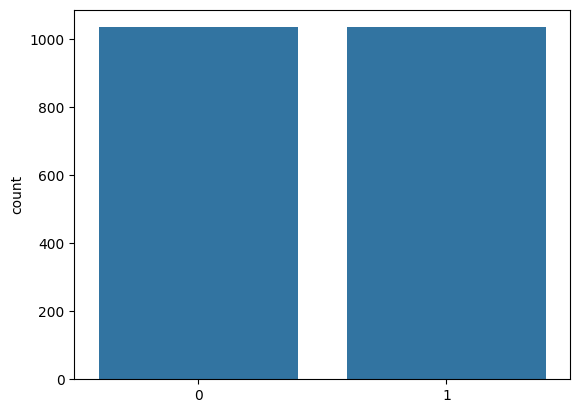

In [107]:
# Apply SMOTE to balance dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
sb.countplot(x=Y)

Text(0.5, 1.0, 'Quantile')

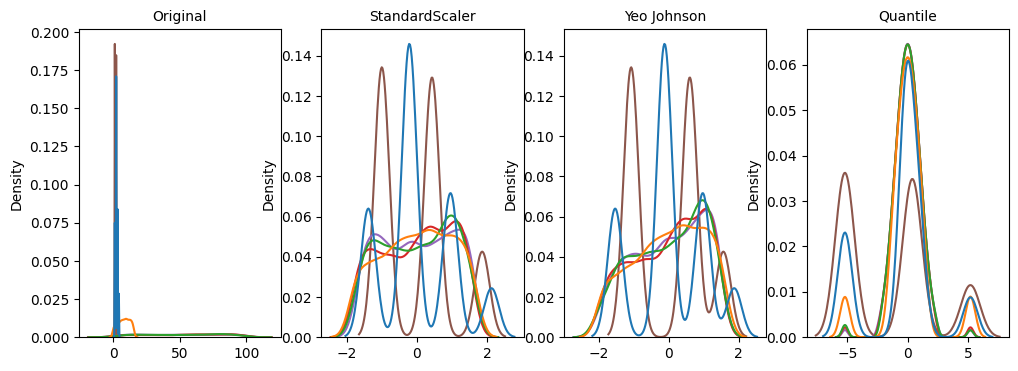

In [108]:
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

q_transformer = QuantileTransformer(output_distribution='normal')
p_transformer = PowerTransformer(method='yeo-johnson')
X_quantile = q_transformer.fit_transform(X)
X_yeo = p_transformer.fit_transform(X)

fig, axis = plt.subplots(1, 4, figsize=(12, 4))
sb.kdeplot(X, ax=axis[0], legend=False,)
axis[0].set_title('Original', size=10)

sb.kdeplot(X_standard, ax=axis[1], legend=False,)
axis[1].set_title('StandardScaler', size=10)

sb.kdeplot(X_yeo, ax=axis[2], legend=False)
axis[2].set_title('Yeo Johnson', size=10)

sb.kdeplot(X_quantile, ax=axis[3], legend=False)
axis[3].set_title('Quantile', size=10)

In [109]:
# Split dataset in training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=random_seed)

# Transform dataset
X_train_scaled = q_transformer.transform(X_train)
X_test_scaled = q_transformer.transform(X_test)

In [110]:
param_dist = {
  'n_estimators': randint(50,500),
  'max_depth': randint(1,20)
}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(
  rf, 
  param_distributions = param_dist, 
  n_iter=5, 
  cv=5
)

rand_search.fit(X_train_scaled, y_train)
y_pred = rand_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9355877616747182


In [111]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 12, 'n_estimators': 392}


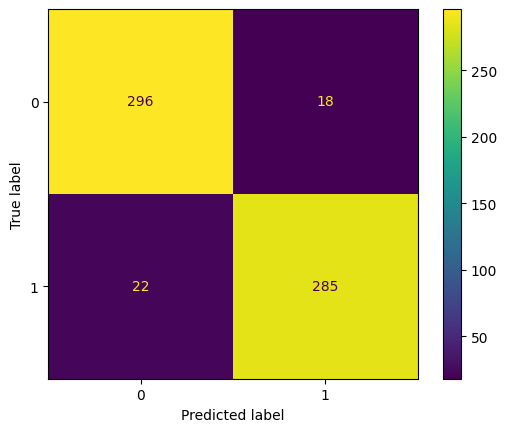

In [112]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [113]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9355877616747182
Precision: 0.9405940594059405
Recall: 0.9283387622149837


<Axes: >

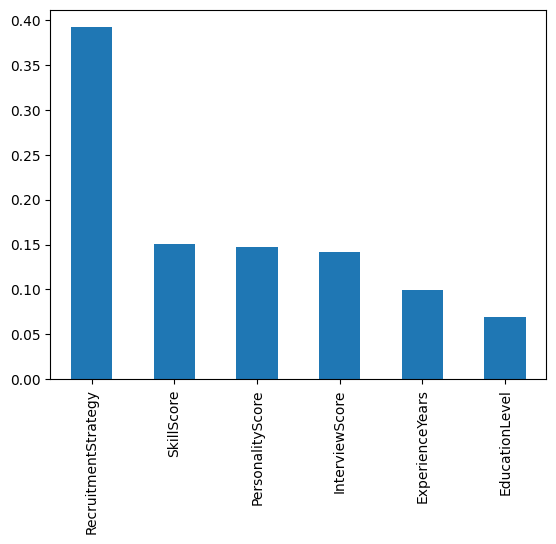

In [114]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(
  best_rf.feature_importances_,
  index=dataset[features].columns
).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()